# Kernel SVM Scratch

✅간략한 설명
* 확장된 feature space에서 찾은 decision boundary를 원 feature space에 projection 시킴으로써 nonlinear decision boundary를 얻음 
* Feature의 수가 많아지면 hyperplane을 찾는 최적화 문제를 풀기 위한 계산량이 급격히 증가하는데, kernel이라는 개념을 활용하여 feature의 수가 크게 증가하더라도 계산량의 증가 없이 hyperplane을 찾을 수 있음 
<br/>

![](img/2022-11-03-13-54-39.png)
<br/>

**자세한 설명은 [README](https://github.com/Moonmoonji/Business_Analytics-2022-/blob/main/Kernel-based%20Learning/README.md)에 나와있습니다** 👌

✅튜토리얼 구성 
1. [라이브러리 불러오기 및 시각화 함수](#라이브러리-import-및-plotting-모듈)
2. [데이터 생성](#데이터-생성) 
3. [XOR 문제에 기존 방법 적용](#xor-문제에-대한-logistic-regression-lda-결과)
4. [Kernel SVM 수식 기반 구현](#kernel-trick-수식-기반-구현)
5. [Kenel SVM Scikit Learn으로 구현](#scikit-learn-사용한-구현)
4. [수식 기반 구현 vs 사이킷런](#성능-평가-수식-기반-구현-vs-사이킷런)

### 라이브러리 import 및 plotting 모듈 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as pltcolors
from sklearn import linear_model, svm, discriminant_analysis, metrics
from scipy import optimize
import seaborn as sns

In [2]:
def plotLine(ax, xRange, w, x0, label, color='grey', linestyle='-', alpha=1.):
    """ Plot a (separating) line given the normal vector (weights) and point of intercept """
    if type(x0) == int or type(x0) == float or type(x0) == np.float64:
        x0 = [0, -x0 / w[1]]
    yy = -(w[0] / w[1]) * (xRange - x0[0]) + x0[1]
    ax.plot(xRange, yy, color=color, label=label, linestyle=linestyle)
    
def plotSvm(X, y, support=None, w=None, intercept=0., label='Data', separatorLabel='Separator', 
            ax=None, bound=[[-1., 1.], [-1., 1.]]):
    """ Plot the SVM separation, and margin """
    if ax is None:
        fig, ax = plt.subplots(1)
    
    im = ax.scatter(X[:,0], X[:,1], c=y, cmap=cmap, alpha=0.5, label=label)
    if support is not None:
        ax.scatter(support[:,0], support[:,1], label='Support', s=80, facecolors='none', 
                   edgecolors='y', color='y')
        print("Number of support vectors = %d" % (len(support)))
    if w is not None:
        xx = np.array(bound[0])
        plotLine(ax, xx, w, intercept, separatorLabel)
        # Plot margin
        if support is not None:
            signedDist = np.matmul(support, w)
            margin = np.max(signedDist) - np.min(signedDist) * np.sqrt(np.dot(w, w))
            supportMaxNeg = support[np.argmin(signedDist)]
            plotLine(ax, xx, w, supportMaxNeg, 'Margin -', linestyle='-.', alpha=0.8)
            supportMaxPos = support[np.argmax(signedDist)]
            plotLine(ax, xx, w, supportMaxPos, 'Margin +', linestyle='--', alpha=0.8)
            ax.set_title('Margin = %.3f' % (margin))
    ax.legend(loc='upper left')
    ax.grid()
    ax.set_xlim(bound[0])
    ax.set_ylim(bound[1])
    cb = plt.colorbar(im, ax=ax)
    loc = np.arange(-1,1,1)
    cb.set_ticks(loc)
    cb.set_ticklabels(['-1','1'])

In [22]:
# Heatmap, Confusion Matrix 구하는 코드 
def plotHeatMap(X, classes, title=None, fmt='.2g', ax=None, xlabel=None, ylabel=None):
    """ Fix heatmap plot from Seaborn with pyplot 3.1.0, 3.1.1
        https://stackoverflow.com/questions/56942670/matplotlib-seaborn-first-and-last-row-cut-in-half-of-heatmap-plot
    """
    ax = sns.heatmap(X, xticklabels=classes, yticklabels=classes, annot=True, fmt=fmt, cmap=plt.cm.Blues, ax=ax) #notation: "annot" not "annote"
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    if title:
        ax.set_title(title)
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)
        
def plotConfusionMatrix(yTrue, yEst, classes, title=None, fmt='.2g', ax=None):
    plotHeatMap(metrics.confusion_matrix(yTrue, yEst), classes, title, fmt, ax, xlabel='Estimations', ylabel='True values');

## 데이터 생성 
: XOR 문제를 갖는 데이터 셋을 생성한다 

In [9]:
colors = ['red','green']
cmap = pltcolors.ListedColormap(colors)
nFeatures = 2
N = 100

In [10]:
def generateBatchXor(n, mu=0.5, sigma=0.5):
    """ Four gaussian clouds in a Xor fashion """
    X = np.random.normal(mu, sigma, (n, 2))
    yB0 = np.random.uniform(0, 1, n) > 0.5
    yB1 = np.random.uniform(0, 1, n) > 0.5
    # y is in {-1, 1}
    y0 = 2. * yB0 - 1
    y1 = 2. * yB1 - 1
    X[:,0] *= y0
    X[:,1] *= y1
    X -= X.mean(axis=0)
    return X, y0*y1

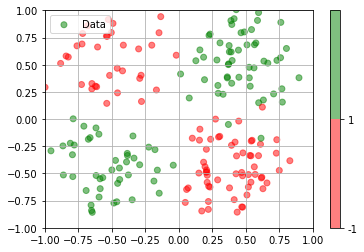

In [11]:
xTrain3, yTrain3 = generateBatchXor(2*N, sigma=0.25)
plotSvm(xTrain3, yTrain3)
xTest3, yTest3 = generateBatchXor(2*N, sigma=0.25)

## XOR 문제에 대한 Logistic Regression, LDA 결과

In [12]:
model32 = linear_model.LogisticRegression(solver='lbfgs')
model32.fit(xTrain3, yTrain3)
model32.coef_[0], model32.intercept_[0]

(array([-0.20086121,  0.4854685 ]), 0.041117469153331754)

In [13]:
model33 = discriminant_analysis.LinearDiscriminantAnalysis(solver='svd')
model33.fit(xTrain3, yTrain3)
model33.coef_[0], model33.intercept_[0]

(array([-0.21327023,  0.51737685]), 0.04094023084956344)

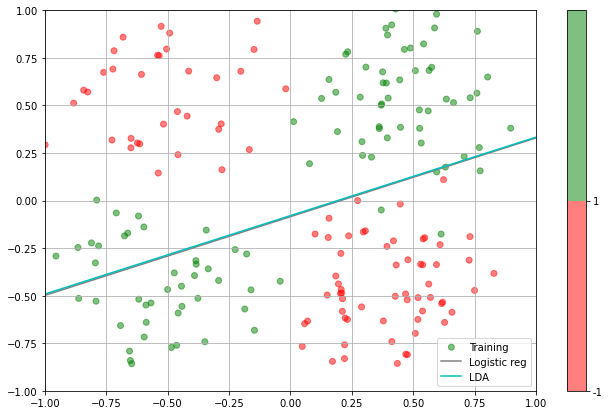

In [14]:
fig, ax = plt.subplots(1, figsize=(11, 7))
plotSvm(xTrain3, yTrain3, w=model32.coef_[0], intercept=model32.intercept_[0], label='Training',
        separatorLabel='Logistic reg', ax=ax)
xx = np.array([-1., 1.])
plotLine(ax, xx, w=model33.coef_[0], x0=model33.intercept_[0], label='LDA', color='c')
ax.legend();

## Kernel trick 수식 기반 구현 

Kernel trick을 사용하면 라그랑지안 듀얼 문제가 아래 수식과 같이 변경 : 
$$\begin{align}
\mathcal{L}_d (\alpha)
&= \sum_{i=0}^n \alpha_i - \frac 12 \sum_{i=0}^n \sum_{k=0}^n \alpha_i \alpha_k y_i y_k h(x_i)^T h(x_k) \\
&= \sum_{i=0}^n \alpha_i - \frac 12 \sum_{i=0}^n \sum_{k=0}^n \alpha_i \alpha_k \langle y_i h(x_i), y_k  h(x_k) \rangle \\
\end{align}$$

__Subject to $\forall i\in 1..n$:__
- $0 \le \alpha_i \le C$
- $\sum_{i=0}^n \alpha_i y_i = 0$

### G-RBF Kernel 구현 
: 유튜브 영상에서도 설명했듯이 RBF 커널이 가장 일반적으로 많이 사용됨

In [15]:
class KernelSvmClassifier:
    
    def __init__(self, C, kernel):
        self.C = C                               
        self.kernel = kernel          # <---
        self.alpha = None
        self.supportVectors = None
    
    def fit(self, X, y):
        N = len(y)
        # --->
        # Gram matrix of h(x) y
        hXX = np.apply_along_axis(lambda x1 : np.apply_along_axis(lambda x2:  self.kernel(x1, x2), 1, X),
                                  1, X)   
        yp = y.reshape(-1, 1)
        GramHXy = hXX * np.matmul(yp, yp.T) 
        # <---

        # Lagrange dual problem
        def Ld0(G, alpha):
            return alpha.sum() - 0.5 * alpha.dot(alpha.dot(G))

        # Partial derivate of Ld on alpha
        def Ld0dAlpha(G, alpha):
            return np.ones_like(alpha) - alpha.dot(G)

        # Constraints on alpha of the shape :
        # -  d - C*alpha  = 0
        # -  b - A*alpha >= 0
        A = np.vstack((-np.eye(N), np.eye(N)))             # <---
        b = np.hstack((np.zeros(N), self.C * np.ones(N)))  # <---
        constraints = ({'type': 'eq',   'fun': lambda a: np.dot(a, y),     'jac': lambda a: y},
                       {'type': 'ineq', 'fun': lambda a: b - np.dot(A, a), 'jac': lambda a: -A})

        # Maximize by minimizing the opposite
        optRes = optimize.minimize(fun=lambda a: -Ld0(GramHXy, a),
                                   x0=np.ones(N), 
                                   method='SLSQP', 
                                   jac=lambda a: -Ld0dAlpha(GramHXy, a), 
                                   constraints=constraints)
        self.alpha = optRes.x
        # --->
        epsilon = 1e-8
        supportIndices = self.alpha > epsilon
        self.supportVectors = X[supportIndices]
        self.supportAlphaY = y[supportIndices] * self.alpha[supportIndices]
        # <---
    
    def predict(self, X):
        """ Predict y values in {-1, 1} """
        # --->
        def predict1(x):
            x1 = np.apply_along_axis(lambda s: self.kernel(s, x), 1, self.supportVectors)
            x2 = x1 * self.supportAlphaY
            return np.sum(x2)
        
        d = np.apply_along_axis(predict1, 1, X)
        return 2 * (d > 0) - 1
        # <---

In [16]:
def GRBF(x1, x2):
    diff = x1 - x2
    return np.exp(-np.dot(diff, diff) * len(x1) / 2)

model30 = KernelSvmClassifier(C=5, kernel=GRBF)
model30.fit(xTrain3, yTrain3)

Number of support vectors = 36


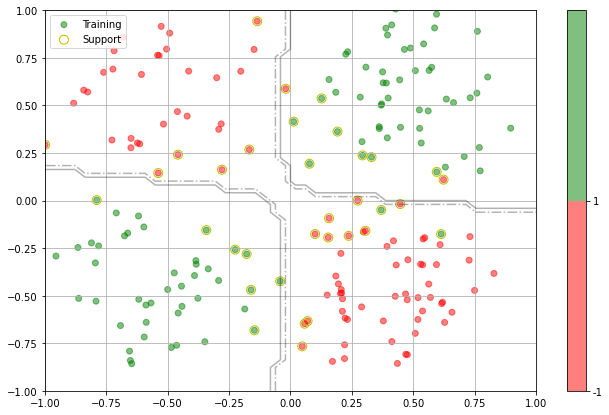

In [17]:
fig, ax = plt.subplots(1, figsize=(11, 7))
plotSvm(xTrain3, yTrain3, support=model30.supportVectors, label='Training', ax=ax)

# Estimate and plot decision boundary
xx = np.linspace(-1, 1, 50)
X0, X1 = np.meshgrid(xx, xx)
xy = np.vstack([X0.ravel(), X1.ravel()]).T
Y30 = model30.predict(xy).reshape(X0.shape)
ax.contour(X0, X1, Y30, colors='k', levels=[-1, 0], alpha=0.3, linestyles=['-.', '-']);

## Scikit learn 사용한 구현 

In [18]:
model31 = svm.SVC(kernel='rbf', C=10, gamma=1/2, shrinking=False)
model31.fit(xTrain3, yTrain3);

Number of support vectors = 39


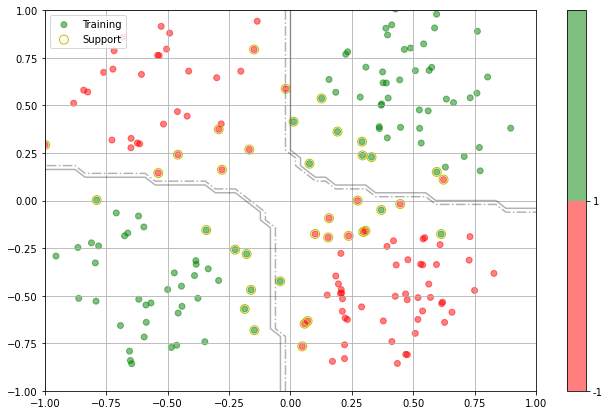

In [19]:
fig, ax = plt.subplots(1, figsize=(11, 7))
plotSvm(xTrain3, yTrain3, support=model31.support_vectors_, label='Training', ax=ax)

# Estimate and plot decision boundary
Y31 = model31.predict(xy).reshape(X0.shape)
ax.contour(X0, X1, Y31, colors='k', levels=[-1, 0], alpha=0.3, linestyles=['-.', '-']);

## 성능 평가 (수식 기반 구현 vs 사이킷런)

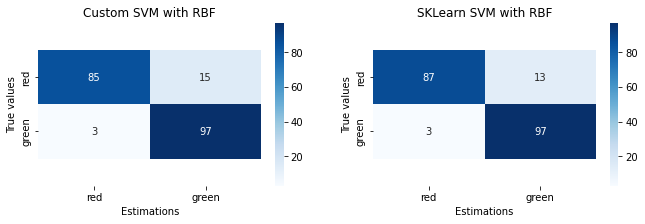

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(11, 3))
for model, ax, title in zip([model30, model31], axes, ["Custom SVM with RBF", "SKLearn SVM with RBF"]):
    yEst3 = model.predict(xTest3)
    plotConfusionMatrix(yTest3, yEst3, colors, title, ax=ax)

🔎 결과 해석 :
<br/>
사이킷런으로 kernel svm을 구현한 결과와, 수식을 기반으로 구현 결과의 confusion matrix를 비교해봤는데 거의 성능 차이가 없다. 
<br/>
이 실험은 데이터셋 자체의 수가 많지 않아서 시간도 얼마 안걸리고 결과가 비슷한 것 같은데, 데이터의 크기가 더 커질때는 어떤 차이가 있는지 비교해 봐야 할 것 같다. 